# Micro-narrative analysis of _The Lord of the Rings_

In [1]:
import glob
import os.path

docs = []
for file in glob.glob("input/*.txt"):
    with open(file) as f:
        text = f.read()
        sections = text.split("\n")
        for section in sections:
            section = section.strip()
            if section:
                docs.append(section)

In [2]:
from narrativegraph import NarrativeGraph
from narrativegraph.nlp.extraction.spacy import NaiveSpacyTripletExtractor

if os.path.exists("lotr.sqlite"):
    model = NarrativeGraph.load("lotr.sqlite")
else:
    model = NarrativeGraph(
        triplet_extractor=NaiveSpacyTripletExtractor(
            named_entities=(1, None),
            noun_chunks=(2, None),
        ),
        sqlite_db_path="lotr.sqlite",
        on_existing_db="overwrite"
    ).fit(docs)

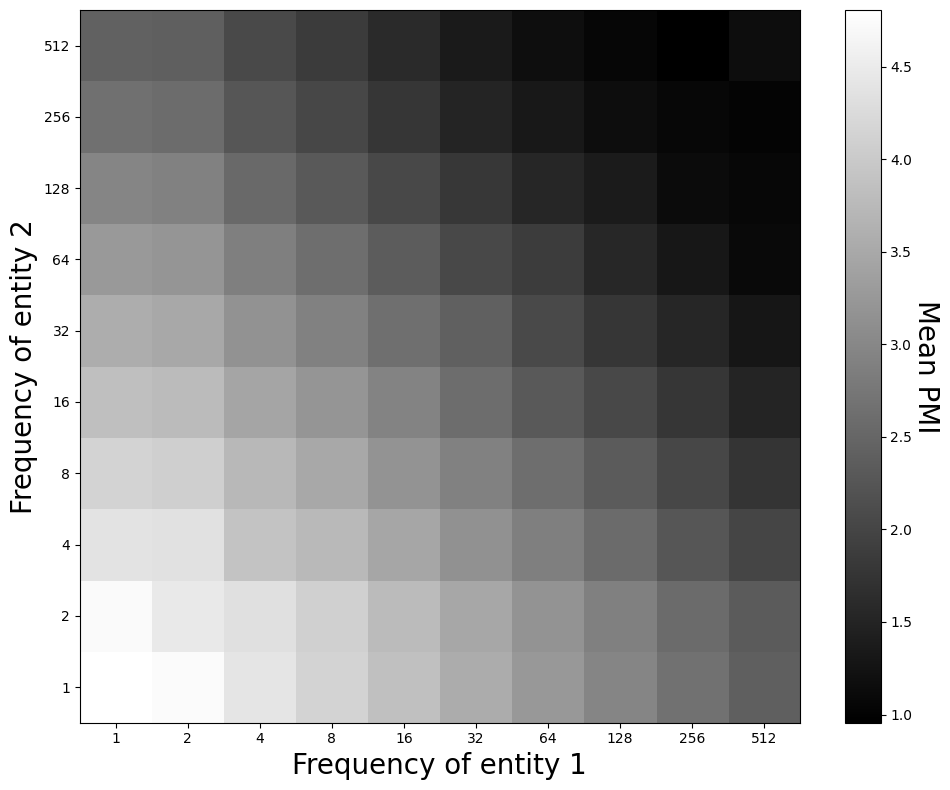

In [3]:
from sharedutils import visualize_pmi_by_frequency

visualize_pmi_by_frequency(model.co_occurrences_)

In [5]:
from narrativegraph import GraphFilter

graph_filter = GraphFilter(
    minimum_edge_frequency=2,
    minimum_node_frequency=2,
    maximum_node_frequency=100,
    maximum_edge_doc_frequency=20
)

In [12]:
comms = model.graph.find_communities(
    graph_filter=graph_filter,
    min_weight=2,
    community_detection_method_args=dict(k=3)
)

for comm in sorted(comms, key=lambda c: c.score, reverse=True):
    if len(comm.members) < 2: continue
    print(*[e.label for e in comm.members], sep=", ")
    print()

O Orofarnë, Lassemista, Carnimírië

the upper portion, his reach, a loose veil

the spider, the hawk, the eagle's foot

the left-hand passage, the same general direction, only brief halts, the right-hand, the middle way, three passages

early evening, the bare branches, the dark pines, The East Wind

Mauhúr, better night-eyes, his lads, Whiteskins

a few mouthfuls, lembas_, his master's face

his large mouth, A sneer, dark scornful eyes

the right way, thirteen dwarves, one hobbit

a snow-mountain, a lass, as merry

faint drums, wooded hills, a blanket

your death, this death, your people, your father, your part

a cold rain, A shudder, the slap, a keen air

West-door, a direct line, East-gate, our way

iron rim, the coat, a black cap, a tunic, a full-sized orc, stout ring-mail

the beans, long clouds, red flowers, pale morning, soiled wool, the sunrise

his nose, a wide-brimmed hat, the hood

Esgaroth on the Long Lake, ancient history, my _birthday, the occasion, my memory, a fact, th

In [11]:
comms = model.graph.find_communities(
    graph_filter=graph_filter,
    community_detection_method="louvain",
    min_weight=1.5,
    community_detection_method_args=dict(resolution=5)
)
for comm in sorted(comms, key=lambda c: c.score, reverse=True):
    members = [e.label for e in comm.members]
    print(*members, sep=", ")
    print()

The thieves, my precious

O Orofarnë, Lassemista, Carnimírië

my news, no accident

your whole plan, your plans

a secret gate, A new road

Forest River, whose folk

Captain of Gondor, your city

your glass, your box

the upper portion, his reach, a loose veil

the spider, the hawk, the eagle's foot

Ilmarin, the strand

hideous arms, black tunnels

many footprints, much scent

no dint, your hat

the great stone slab, six feet

the blessing, the left eye

a grasshopper, a jump

a vast crescent, the nearest point

his little fire, the sunny bank

intricate shape, two great black keys

low well-laid hedges, a huge turnip-field

the Lords of the Mark, the twenty-first, the Chamber of Mazarbul, their supper, Fréa, the Hall, Fréawine, Goldwine, Helm's Deep, the narrow bridge, Folca, Aldor brother, the funeral, Young, Thengel, open war, Brego, Léofa, Gram, the garrison, The Men of the Mark, the mounds, our visits, the west-side, Folcwine, the hapless, Helm, the east-side, golden halls, Déor,

In [ ]:
# create server to be viewed in own browser which blocks execution of other cells
model.serve_visualizer()

INFO:     Started server process [3070]
INFO:     Waiting for application startup.
INFO:root:Database engine provided to state before startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8001 (Press CTRL+C to quit)


INFO:     127.0.0.1:61518 - "GET / HTTP/1.1" 307 Temporary Redirect
INFO:     127.0.0.1:61518 - "GET /vis HTTP/1.1" 307 Temporary Redirect
INFO:     127.0.0.1:61521 - "GET /graph/bounds HTTP/1.1" 200 OK
INFO:     127.0.0.1:61521 - "OPTIONS /graph HTTP/1.1" 200 OK
INFO:     127.0.0.1:61521 - "POST /graph HTTP/1.1" 307 Temporary Redirect
INFO:     127.0.0.1:61521 - "OPTIONS /graph/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:61521 - "POST /graph/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:61521 - "POST /graph HTTP/1.1" 307 Temporary Redirect
INFO:     127.0.0.1:61521 - "POST /graph/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:61521 - "GET /entities/5141 HTTP/1.1" 200 OK
INFO:     127.0.0.1:61521 - "GET /entities/5141/docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:61525 - "POST /graph HTTP/1.1" 307 Temporary Redirect
INFO:     127.0.0.1:61525 - "POST /graph/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:61529 - "GET /entities/3544 HTTP/1.1" 200 OK
INFO:     127.0.0.1:61529 - "POST /graph HTTP/1.1" 307 Temporary Redirect
I